In [3]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date, timedelta
from common import date_util
from data import investment_universe, sharadar_prices, sharadar_tickers

In [4]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
factor_summary = {}

In [5]:
factor = "momentum"
pnl = []
sector_level_pnl = {}
dates = []
rebal_date = date(1999, 1, 1)
while rebal_date <= date(2019, 12, 31):
    rebal_date = date_util.get_next_rebal_day(rebal_date, 3)

    universe = investment_universe.get_SPX(rebal_date)
    prices = sharadar_prices.get_prices(universe['ticker'].to_list(), rebal_date, date_util.get_next_rebal_day(rebal_date, 3))
    price_df = prices[["ticker", "closeadj", "forward_return"]]
    sectors = sharadar_tickers.get_tickers(universe['ticker'].to_list(), rebal_date)
    sectors = sectors[["ticker", "sector"]]

    previous_month = date_util.get_bus_date(rebal_date - timedelta(weeks=4))
    previous_month_df = sharadar_prices.get_prices(universe['ticker'].to_list(), previous_month)
    previous_month_df = previous_month_df[["ticker", "closeadj"]]

    previous_year = date_util.get_bus_date(rebal_date - timedelta(weeks=52))
    previous_year_df = sharadar_prices.get_prices(universe['ticker'].to_list(), previous_year)
    previous_year_df = previous_year_df[["ticker", "closeadj"]]

    universe = pd.merge(universe, sectors, left_on="ticker", right_on="ticker", how="inner")
    fundamentals = pd.merge(universe, price_df, left_on="ticker", right_on="ticker", how="inner")
    fundamentals = pd.merge(fundamentals, previous_month_df, left_on="ticker", right_on="ticker", how="inner", suffixes=["", "_1m"])
    fundamentals = pd.merge(fundamentals, previous_year_df, left_on="ticker", right_on="ticker", how="inner", suffixes=["", "_1y"])
    fundamentals.loc[fundamentals["sector"] == "Real Estate", "sector"] = "Financial Services"

    if fundamentals.empty:
        continue
    dates.append(rebal_date)

    fundamentals["momentum"] = (fundamentals["closeadj_1m"] / fundamentals["closeadj_1y"] - 1) - (fundamentals["closeadj"] / fundamentals["closeadj_1m"] - 1)

    fundamentals["momentum_z"] = fundamentals.groupby("sector", group_keys=False)["momentum"].apply(lambda x: (x - np.mean(x)) / np.std(x))

    fundamentals["composite"] = fundamentals["momentum_z"]

    fundamentals = fundamentals.sort_values("composite", ascending=False)
    fundamentals = fundamentals[~fundamentals["composite"].isna()]

    pnl.append(fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)]["forward_return"].mean() - 
                fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)]["forward_return"].mean())
    longs = fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
    shorts = fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
    sector_pnl = pd.merge(longs, shorts, left_index=True, right_index=True, suffixes=["_l", "_s"])
    sector_pnl["forward_return"] = sector_pnl["forward_return_l"] / sector_pnl["ticker_l"] - sector_pnl["forward_return_s"] / sector_pnl["ticker_s"]
    sector_level_pnl[rebal_date] = sector_pnl["forward_return"].to_list()
    

sector_level_pnl_df = pd.DataFrame.from_dict(sector_level_pnl, orient='index')
factor_array = []
pnl = np.array(pnl)
pnl[np.isnan(pnl)] = 0
factor_array.append(np.mean(pnl) * 52)
factor_array.append(np.std(pnl) * np.sqrt(52))
factor_array.append(np.mean(pnl) / np.std(pnl) * np.sqrt(52))
cum_returns = np.cumprod(pnl + 1) - 1
high_watermark = np.maximum.accumulate(cum_returns)
drawdown = high_watermark - cum_returns
factor_array.append(np.max(drawdown))
factor_array.append(len(pnl[pnl >= 0]) / len(pnl))
factor_array.append(np.mean(pnl[pnl >= 0]))
factor_array.append(np.mean(pnl[pnl < 0]))
factor_array.append(np.max(pnl))
factor_array.append(np.min(pnl))
factor_array.append(np.mean(pnl[:120]) * 12)
factor_array.append(np.std(pnl[:120]) * np.sqrt(12))
factor_array.append(np.mean(pnl[:120]) / np.std(pnl[:120]) * np.sqrt(12))
factor_array.append(np.mean(pnl[120:]) * 12)
factor_array.append(np.std(pnl[120:]) * np.sqrt(12))
factor_array.append(np.mean(pnl[120:]) / np.std(pnl[120:]) * np.sqrt(12))
factor_array.extend(sector_level_pnl_df.sum(axis=0).to_list())
factor_summary[factor] = factor_array

In [6]:
pd.DataFrame.from_dict(factor_summary, orient='index').to_csv("factor_summary.csv")

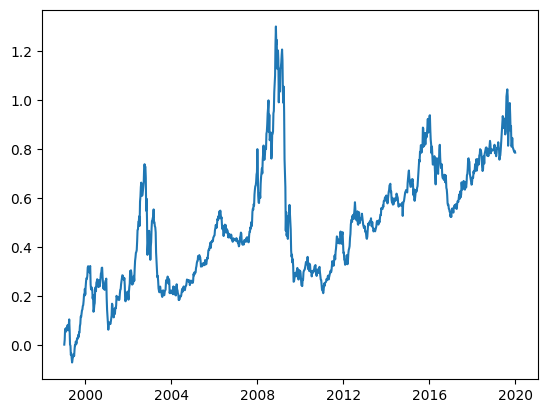

In [7]:
plt.plot(dates, (np.cumprod(pnl + 1) - 1))